In [1]:
import torch 
from torch import nn 
import pandas as pd
from torch import optim 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np 
import random 
import timeit
from tqdm import tqdm

### ViT Architecture from the 16x16 words paper

![vit_architecture](ViT_architecture.png)
 

# Hyperparameters

In [3]:
## Added Params (for training and testing)
RANDOM_SEED = 42
BATCH_SIZE = 512 
EPOCHS = 40 ##why this high number? usually for transformers you do 1,2,3. 

##
LEARNING_RATE = 1e-4
NUM_CLASSES = 10 #because MNIST
PATCH_SIZE = 4 #we chose 4-> pixel length of 1 dimension
IMAGE_SIZE = 56 #The MNIST dataset images are 28 × 28 pixels in size. (H,W) = (28, 28) 
IN_CHANNELS = 1 #MNIST only has 1 channel (Grayscale). Note: RGB would be 3 channels. 
NUM_HEADS = 8 #Within the transformer encoder there are attention heads- we choose 8 of them.                           
DROPOUT = 0.001 
HIDDEN_DIM = 768 #hidden dimentsion of MLP head for classification 
ADAM_WEIGHT_DECAY = 0 # paper uses 0.1, set it to 0 (defautl value)
ADAM_BETAS = (0.9, 0.999) # again from paper. 

ACTIVATION = "gelu" #again use the same as the paper 
NUM_ENCODER = 4 #stack encoders on top of each other (architecture just shows one)


##This is the input size to the patch embedding layer (aka flattening image into sequence of patches )
EMBED_DIM = 64 # 16 -> basically the number of patches

## Paper defines the below as: N =HW / P^2
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2 # 49


random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "cude" if torch.cuda.is_available() else "cpu"

In [4]:
#OVERWRITE PARAMS TO TRAIN ON MY COMPUTER
BATCH_SIZE = 512 #change to 256 if memory cant handle 512
EPOCHS = 6
NUM_HEADS = 4
HIDDEN_DIM = 128
NUM_ENCODER = 3

# Patch Embedding

In [6]:
# Creating CLS Tokens and merging with Positional Embeddings 

class PatchEmbedding(nn.Module):
    def __init__(self, embedding_dim, patch_size, num_patches, dropout, in_channels): 
        super().__init__()
        
        #function that divides images into patches
        self.patcher = nn.Sequential(
            # all Conv2d does is divide our image into patch sizes
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embedding_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ), 
            nn.Flatten(start_dim=2)) #equivalent to nn.Flatten(start_dim=2, end_dim=-1) -> not a learnable layer (converts patched into sequence of vectors)
        
            #OUTPUT SHAPE: (batch_size, embedding_dim, num_patches) AKA the full sequence of patches
            
        
        #---- CLS Token ---- 
     
        #here we define the [CLS] token. nn.Parameter is a learnable tensor (its a single parameter not a full layer)
        # Create a random tensor of shape (1, in_channels, embedding_dim), wrap it as a learnable parameter, and assign it as the CLS token
        self.cls_token = nn.Parameter(torch.randn(size=(1,in_channels,embedding_dim)), requires_grad=True)
        
        
        #---- Positional Embedding ---- 
        
        
        #positional embedding is a learnable parameter 
        self.position_embedding = nn.Parameter(torch.randn(size=(1,num_patches+1,embedding_dim)), requires_grad=True) #we add 1 to num_patches because we have the [CLS] token
        
        self.dropout = nn.Dropout(dropout)
    
    
    #after patching and flattening we have a tesnor of shape (batch_size, embedding_dim, num_patches) e.g., (32, 16, 49)
    # x = x.permute(0, 2, 1) rearranges to (batch_size, num_patches, embedding_dim) e.g., (32, 49, 16)
        
        
        
        
    def forward(self, x): 
        #here we expand the cls token so its not just the shape for 1 sample but for a batch of images
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) #expand the cls token to the batch size. x.shape[0] is the batch size. -1, -1 tells expand function to keep original dimensions. 
        x = self.patcher(x).permute(0,2,1) # first patch x through patcher -> where nn.Conv2d: splits x into patches and embeds them, nn.Flatten(start_dim=2) converts into 1D sequence
        
        #1 axis for batches, 1 axis for sequence of patches, 1 axis for embedding dimension 
        x = torch.cat([cls_token, x], dim=1) #so we want to add the CLS token to the left of the patches
        
        #then we need to add the position tokens to each patch 
        x = self.position_embedding + x
        
        x = self.dropout(x)
        return x


#always test model after you define it    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)  
x = torch.randn(512, 1, 56, 56).to(device)   #create dummy image of batch size 512, channels 1, and dimensions 28x28 
print(model(x).shape) #expect (512, 50, 16) where batch size 512, 50 is number of tokens we feed transformer (correct because we have 49 patches + CLS token), 16 is size of patches (embedding dimension)

torch.Size([512, 197, 64])


# Encoder 

In [7]:
import math
# === Helper activation ========================================================
class NewGELUActivation(nn.Module):                       # same formula as HF
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0)) * (x + 0.044715 * torch.pow(x, 3))
        ))

# === 1. One attention head ====================================================
class AttentionHead(nn.Module):
    def __init__(self, hidden_size: int, head_dim: int, dropout: float,
                 bias: bool = True):
        super().__init__()
        self.head_dim = head_dim
        self.q = nn.Linear(hidden_size, head_dim, bias=bias)
        self.k = nn.Linear(hidden_size, head_dim, bias=bias)
        self.v = nn.Linear(hidden_size, head_dim, bias=bias)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):                                 # x: (B, S, D)
        q, k, v = self.q(x), self.k(x), self.v(x)         # (B,S,d_h) each
        attn = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = self.drop(attn.softmax(dim=-1))            # (B,S,S)
        return attn @ v                                   # (B,S,d_h)

# === 2. Multi-head self-attention =============================================
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 dropout: float = DROPOUT,
                 qkv_bias: bool = True):
        super().__init__()
        assert hidden_size % num_heads == 0, "Hidden dim not divisible by heads"
        head_dim = hidden_size // num_heads
        self.heads = nn.ModuleList([
            AttentionHead(hidden_size, head_dim, dropout, qkv_bias)
            for _ in range(num_heads)
        ])
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):                                 # x: (B,S,D)
        # list of (B,S,d_h) → cat on last dim → (B,S,D)
        x = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.drop(self.out_proj(x))                # (B,S,D)

# === 3. Position-wise feed-forward (MLP) ======================================
class MLP(nn.Module):
    def __init__(self, hidden_size: int = EMBED_DIM,
                 intermediate_size: int = HIDDEN_DIM * 4,
                 dropout: float = DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            NewGELUActivation(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(dropout)
        )
    def forward(self, x):                                 # (B,S,D) -> (B,S,D)
        return self.net(x)

# === 4. Transformer block =====================================================
class Block(nn.Module):
    def __init__(self, hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 mlp_ratio: int = 4,
                 dropout: float = DROPOUT):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_size)
        self.attn = MultiHeadAttention(hidden_size, num_heads, dropout)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.mlp = MLP(hidden_size, hidden_size * mlp_ratio, dropout)

    def forward(self, x):                                 # (B,S,D)
        x = x + self.attn(self.ln1(x))                    # SA + residual
        x = x + self.mlp(self.ln2(x))                     # MLP + residual
        return x                                          # (B,S,D)

# === 5. Encoder = N stacked blocks ============================================
class Encoder(nn.Module):
    def __init__(self, depth: int = NUM_ENCODER,
                 hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 dropout: float = DROPOUT):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(hidden_size, num_heads, dropout=dropout)
            for _ in range(depth)
        ])
        self.ln_final = nn.LayerNorm(hidden_size)

    def forward(self, x):                                 # (B,S,D)
        for blk in self.blocks:
            x = blk(x)
        return self.ln_final(x)                           # final norm

# === 6. ViT classifier head (uses Encoder) ====================================
class ViT(nn.Module):
    def __init__(self,
                 num_patches: int = NUM_PATCHES,
                 num_classes: int = NUM_CLASSES,
                 patch_size: int = PATCH_SIZE,
                 embed_dim: int = EMBED_DIM,
                 depth: int = NUM_ENCODER,
                 num_heads: int = NUM_HEADS,
                 dropout: float = DROPOUT,
                 in_channels: int = IN_CHANNELS):
        super().__init__()
        self.embed = PatchEmbedding(embed_dim, patch_size,
                                    num_patches, dropout, in_channels)
        self.encoder = Encoder(depth, embed_dim, num_heads, dropout)
        self.cls_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                                 # x: (B,C,H,W)
        x = self.embed(x)                                 # (B,S,D)
        x = self.encoder(x)                               # (B,S,D)
        cls = x[:, 0]                                     # (B,D)
        return self.cls_head(cls)                         # (B,num_classes)


model = ViT(NUM_PATCHES, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODER, NUM_HEADS, DROPOUT, IN_CHANNELS).to(device)  
x = torch.randn(512, 1, 56, 56) #dummy image
print(model(x).shape) #expect [512, 10] -> batch of 512 (512 images) for 10 classes -> returns 

torch.Size([512, 10])


# Decoder

In [ ]:
sdfds

# Dataset

In [8]:
#Download MNIST dataset 

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)



In [9]:
# ─────────────────────────────────────────────────────────────────────────────
#  Synthetic 2×2–grid dataset (Stage-1 of our encoder-decoder project)
#  Canvas: 56×56   PatchSize: 4  → 14×14 = 196 patch tokens
# ─────────────────────────────────────────────────────────────────────────────
VOCAB = {str(i): i for i in range(10)}
VOCAB['<start>']  = 10
VOCAB['<finish>'] = 11
VOCAB['<pad>']    = 12
PAD_IDX      = VOCAB['<pad>']
SEQ_MAX_LEN  = 6                    #  <start> + up-to-4 digits + <finish>

GRID_SIZE    = 2                    # 2×2 cells
CELL_PIX     = 28
CANVAS_PIX   = GRID_SIZE * CELL_PIX # 56

grid_transforms = transforms.Compose([
    transforms.ToTensor(),                  # uint8 → 0-1
    transforms.Normalize([0.5], [0.5])      # centre to −1..1
])

class GridMNIST(Dataset):
    def __init__(self, base_images, base_labels,
                 epoch_size=60_000, rng=None):
        self.base_images = base_images          # (N,28,28) uint8
        self.base_labels = base_labels          # (N,)
        self.epoch_size  = epoch_size
        self.rng = np.random.default_rng(rng)

        # indices per digit for fast balanced sampling
        self.per_digit = {d: np.where(base_labels == d)[0] for d in range(10)}

        # 15 non-empty cell-occupancy patterns (bitmask 1..15)
        patterns = np.arange(1, 16)
        reps = math.ceil(epoch_size / len(patterns))
        self.pattern_pool = self.rng.permutation(
            np.tile(patterns, reps)[:epoch_size])

    def __len__(self):
        return self.epoch_size

    @staticmethod
    def _cells_from_mask(mask: int):
        return [i for i in range(4) if (mask >> i) & 1]   # TL,TR,BL,BR

    def __getitem__(self, idx):
        mask     = int(self.pattern_pool[idx])
        cell_ids = self._cells_from_mask(mask)

        canvas = np.zeros((CANVAS_PIX, CANVAS_PIX), dtype=np.uint8)
        seq    = [VOCAB['<start>']]

        for cell in cell_ids:
            d = int(self.rng.integers(0, 10))
            img_idx = self.rng.choice(self.per_digit[d])
            digit_img = self.base_images[img_idx]

            row, col = divmod(cell, GRID_SIZE)
            top, left = row*CELL_PIX, col*CELL_PIX
            canvas[top:top+CELL_PIX, left:left+CELL_PIX] = digit_img

            seq.append(VOCAB[str(d)])

        seq.append(VOCAB['<finish>'])
        length = len(seq)
        seq += [PAD_IDX] * (SEQ_MAX_LEN - length)

        return {
            'image'  : grid_transforms(canvas),          # (1,56,56) float
            'target' : torch.tensor(seq, dtype=torch.long),  # (6,)
            'length' : length
        }

# ─── build train / val / test loaders ───────────────────────────────────────
train_grid = GridMNIST(train_dataset.data.numpy(),
                       train_dataset.targets.numpy(),
                       epoch_size=60_000, rng=RANDOM_SEED)

val_grid   = GridMNIST(test_dataset.data.numpy(),   # we reuse MNIST test set
                       test_dataset.targets.numpy(),
                       epoch_size=10_000, rng=RANDOM_SEED+1)

test_grid  = GridMNIST(test_dataset.data.numpy(),
                       test_dataset.targets.numpy(),
                       epoch_size=10_000, rng=RANDOM_SEED+2)

train_dataloader = DataLoader(train_grid, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_grid,   batch_size=BATCH_SIZE, shuffle=False)
test_dataloader  = DataLoader(test_grid,  batch_size=BATCH_SIZE, shuffle=False)


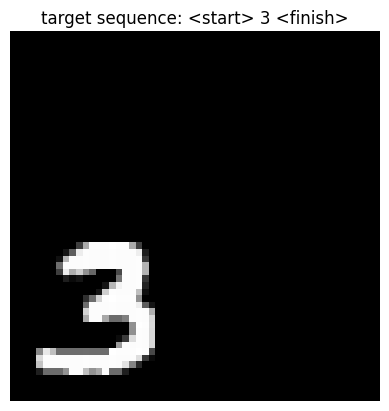

In [10]:
VOCAB_INV = {v: k for k, v in VOCAB.items()}


# quick sanity-check: show a random training sample
sample = next(iter(train_dataloader))
img_grid = sample['image'][0].squeeze().cpu()   # (56,56)
target   = sample['target'][0].tolist()
seq_txt  = ' '.join([str(VOCAB_INV[t]) for t in target if t != PAD_IDX])

plt.imshow(img_grid, cmap='gray')
plt.title(f"target sequence: {seq_txt}")
plt.axis('off')
plt.show()


In [ ]:
#Now we get into training loop 

#define loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY, betas=ADAM_BETAS)

#lets estimate the time it will take to train the model 
start = timeit.default_timer()


#we add 2 more parameters to the tqdm function: position and leave. 
for epoch in tqdm(range(EPOCHS), position =0, leave=True):
    model.train() #take the model into train mode 
    
    #we need to store train labels and predictions for a given epoch so we can calculate the loss and accuracy for that epoch so we initialise empty lists 
    train_labels = [] 
    train_preds = []
    train_running_loss = 0.0 #store runnign losss which will start at 0
     
    #iterate through data loader 
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        #remember we return 'image' from dataset class and its a dataframe which is accessible like a dictionary
        img = img_label['image'].float().to(device)
        label = img_label['label'].type(torch.uint8).to(device) # remember MNIST labels are always integers between 0–9 (digits) so we store as int
        y_pred = model(img)
        
        #recall the output shape is (batch_size, num_classes) aka ([512, 10]), which is a probability distribution over the 10 classes -> so we need to get the index of the highest probability
        
        
        #to predict the label: 
        y_pred_label = torch.argmax(y_pred, dim=1) #take the column with the highest probability and select it -> dim 1 instead of 0 because we look across the rows of [512, 10] which is the classes
        
        #add to train labels. store to cpu when we can to avoid using up GPU memory 
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        #3 lines below ensure that training is happening 
        
        loss = criterion(y_pred, label) #calculate the loss -> returns a scalar tensor
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward() #backpropagate the loss
        optimizer.step() #update the model parameters
        
        #update the loss 
        train_running_loss += loss.item() #stores the loss for all batches in the epoch
    
    #now we update the train loss for the whole epoch     
    train_loss = train_running_loss / len(train_dataloader) #stores the loss for 1 epoch -> average the loss over the number of batches in the epoch. so we have average loss per batch for 1 epoch. len(train_dataloader) = number of batches in the epoch
    
    
    #calculate train accuracy (num of correct predictions / total num of predictions)
    train_acc = sum(x == y for x, y in zip(train_labels, train_preds)) / len(train_labels)

        
    
    
    #take model into evaluation mode 
    model.eval()
    val_labels = [] #store validation labels for a given epoch 
    val_preds = [] #store validation predictions for a given epoch 
    val_running_loss = 0.0 #store running loss for a given epoch 
    
    #no need to track gradients in validation loop aka ensures no learning is happening in validation loop -> since we just want validation score from trained model 
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label['image'].float().to(device)
            label = img_label['label'].type(torch.uint8).to(device)
            y_pred = model(img)
            
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / len(val_dataloader)
    val_acc = sum(x == y for x, y in zip(val_labels, val_preds)) / len(val_labels)

            
     #print as train happens 
    print("-"*30)
    print(f"Train loss EPOCH {epoch+1}: {train_loss:.4f}")       
    print(f"Val loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train acc EPOCH {epoch+1}: {train_acc:.4f}")
    print(f"Val acc EPOCH {epoch+1}: {val_acc:.4f}")
    print("-"*30)
    
stop = timeit.default_timer() 
print(f"Time taken: {stop - start:.2f} seconds")

Outer loop: 
- we loop over epochs

Inner loop: 
- we loop over each batch from the dataloader 


You will see: e.g. 46/106 -> 106 is the number of batches. number of batches = dataset-size/batch-size = (54K) /512 =106 (round up) for train, 6k/512 = 12 (round up) for test. We always round up, last batch may be smaller but we still train on those samples. 

In [ ]:
#free up space in GPU memory 
torch.cuda.empty_cache()

In [ ]:
#continue with prediction on test set 

labels_pred = []

model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample['image'].float().to(device)

        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        labels_pred.extend([int(i) for i in y_pred_label.cpu().detach()])


In [ ]:
#Plot test data and see our predictions 
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0

for i in range(2): #iterate through rows in plot 
    for j in range(3): #iterate through columns in plot 
        axarr[i, j].imshow(img[counter].squeeze(), cmap='gray')
        axarr[i, j].set_title(f"Predicted: {labels_pred[counter]}")
        counter += 1
plt.show()

